In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [72]:
df = pd.read_csv('df.csv')
print(df.shape)
df.head()

(13246, 6)


,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


##### We know the price of house and the size of house. Let's calculate the <em>Price per sqft</em> and save it in new column.

In [77]:
df['price_per_sqft'] = df['price'] * 100000/ df['total_sqft']  # multiplying by 100000(1 lakh) because price is in lakhs
df.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [78]:
print(len(df.location.unique()))
df.location.unique()

1293


array(['Electronic City Phase II', 'Chikka Tirupathi', 'Uttarahalli', ...,
       '12th cross srinivas nagar banshankari 3rd stage',
       'Havanur extension', 'Abshot Layout'], dtype=object)

In [79]:
def change(x):
    return x.strip()

In [80]:
df.location = df.location.apply(change)
location_stats = df.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats.head(10)

location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
Yelahanka                210
Uttarahalli              186
Hebbal                   176
Marathahalli             175
Raja Rajeshwari Nagar    171
Name: location, dtype: int64

##### Let's find out how many location has less than or equal to 10 houses

In [81]:
len(location_stats[location_stats<=10])

1052

##### There are 1052 location which have less than or equal to 10 houses.

In [82]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
BTM 1st Stage          10
Basapura               10
Sector 1 HSR Layout    10
Naganathapura          10
Kalkere                10
                       ..
LIC Colony              1
Kuvempu Layout          1
Kumbhena Agrahara       1
Kudlu Village,          1
1 Annasandrapalya       1
Name: location, Length: 1052, dtype: int64

In [83]:
# a function for separating location less than 10 houses
def other(x):
    if x in location_stats_less_than_10:
        x = other
    else:
        return x

In [84]:
df.location = df.location.apply(other)

In [85]:
len(df.location.unique())

242

##### Before applying the function the count of location.unique was <strong>1293</strong>.
##### After applying the function, the count of location.unique is <strong>242</strong>.

##### So, we successfully separated the values in location feature.

In [86]:
df.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,None,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


#### As we can observe here: 
    1. The size of 1 bedroom is around 500sqft ( total_sqft_avg / bhk ~ 500sqft).
    2. Now we will set some threshold size of 1 bedroom ( say 300 sqft ) and remove those error values( where size < 300)

##### Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely    

In [89]:
len(df[df.total_sqft / df.bhk < 300])  # length of rows with error values

744

In [90]:
df.shape

(13246, 7)

##### As we can see there are 744 rows out of total (13246) rows of size below the threshold size (size< 300sqft)

##### Now we will make a new dataset excluding these(744) error values

In [91]:
df1 = df[~(df.total_sqft/ df.bhk < 300)]
df1.shape

(12502, 7)

##### Now, the number of rows is = 12502

## Outlier Removal Using Standard Deviation and Mean

In [92]:
df1.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

##### Here we find that min price per sqft is 267 rs/sqft whereas max is 176470, this shows a wide variation in property prices. 
##### We should remove outliers per location using mean and one standard deviation

In [93]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df2 = remove_pps_outliers(df1)
df2.shape

(7940, 7)

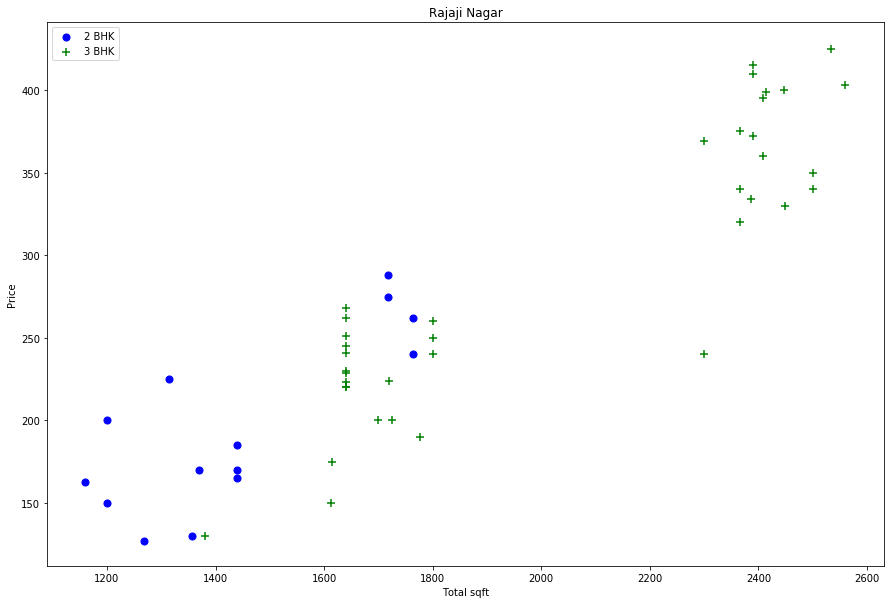

In [103]:
def plot_scatter_chart(df, location):
    bhk2 = df[(df.location == location) & (df.bhk==2)]
    bhk3 = df[(df.location == location) & (df.bhk==3)]
    plt.figure(figsize=(15,10))
    plt.scatter(bhk2.total_sqft, bhk2.price, color='blue', label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft, bhk3.price, marker='+', color='green', label='3 BHK', s=50)
    plt.xlabel('Total sqft')
    plt.ylabel('Price')
    plt.title(location)
    plt.legend()

plot_scatter_chart(df2,"Rajaji Nagar")    

In [96]:
df2.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668
